# 사람 아웃포커싱

In [1]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(4032, 3024, 3)


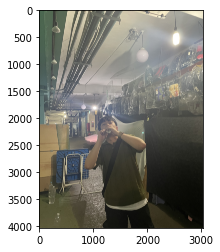

In [2]:
img_path = '/aiffel/aiffel/workspace/09_study/data/my_image.png'
img_orig = cv2.imread(img_path)

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## PixelLib에서 제공하는 모델 다운로드

In [3]:
model_dir = '/aiffel/aiffel/workspace/09_study/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/workspace/08_study/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7ef3224809a0>)

## semantic_segmentation 준비
- 모든 픽셀을 해당하는 (미리 지정된 개수의) class로 분류하는 것
- 각 class를 따로따로 구분하진 않음 (instance segmentation은 각각 다 따로 구분해준다)

In [4]:
#PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model = semantic_segmentation()
# pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
model.load_pascalvoc_model(model_file)

In [5]:
# segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용
segvalues, output = model.segmentAsPascalvoc(img_path)

In [6]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

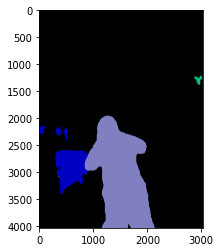

In [7]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [8]:
segvalues

{'class_ids': array([ 0,  9, 15, 19]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [9]:
# 내사진의 class는 배경, 의자, 사람, 기차(?)가있다
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person
train


In [10]:
# PixelLib의 컬러맵 만드는 코드

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [11]:
# 컬러맵에서 사람(15)인 RGB색깔
colormap[15]

array([192, 128, 128])

In [12]:
# output배열은 BGR 이라서 컬러맵의 RGB를 -> BGR로 바꿔줌 (비교하려고)
seg_color = (128,128,192)

(4032, 3024)


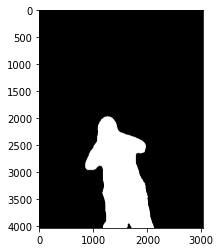

In [13]:
# 사람이 있는곳(백) 뺴고 나머지를 모두 (흑)색으로 출력
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

In [14]:
# 컬러맵에서 train(19)인 RGB색깔
colormap[19]

array([128, 192,   0])

In [15]:
# train 컬러맵 -> RGB
seg_color_train = (0,192,128)

## 문제점(?)이 된 부분

(4032, 3024)


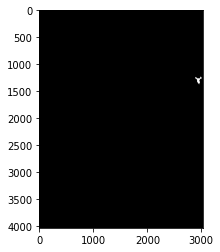

In [16]:
# train이 있는곳(백) 뺴고 나머지(흑)색으로 출력
seg_map_train = np.all(output==seg_color_train, axis=-1) 
print(seg_map_train.shape)
plt.imshow(seg_map_train, cmap='gray')
plt.show()

### OpenCV colormap 공식문서
[opencv colormap 문서](https://docs.opencv.org/3.4/d3/d50/group__imgproc__colormap.html)

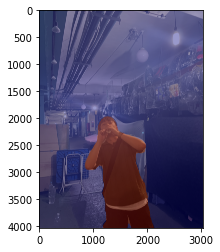

In [17]:
# 원본이미지를 출력용 img_show에 할당
img_show = img_orig.copy()

# 사람이 있는곳은 255로 아닌곳은 0으로
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 opencv의 컬러맵 적용 (JET라는 컬러맵 사용)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 투명도를 원본 이미지 6 컬러마스크 4로 섞기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

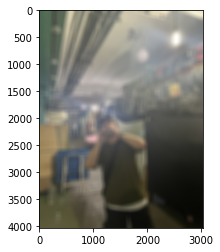

In [18]:
# 두번째 매개변수 (100,100)은 kernel size 숫자가 커질수록 흐려짐
# 커널사이즈가 커지면 그만큼 더 많은 지역정보를 가지기에 흐려지는거
img_orig_blur = cv2.blur(img_orig, (100,100))

# 출력이 BGR 이였으니 RGB로 변경해서 출력
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

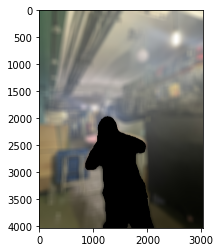

In [19]:
# 밑에서 활용하려고 사람 255, 배경 0인것을 BGR로 저장
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0
img_bg_mask = cv2.bitwise_not(img_mask_color)

# 사람은 0 이기에 bit에서 and 연산 (&&)을 하면 어떤수라도 0이되기에 배경만 구할수 있음
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

## 사람 아웃포커싱 결과물

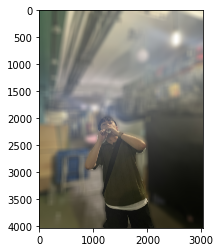

In [20]:
# 사람(255)인 부분은 원본이미지를, 아닌곳은 블러처리된 배경
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

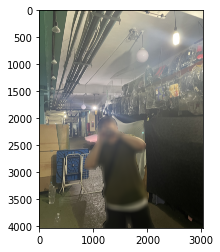

In [21]:
# 사람(255)인 부분은 : 원본이미지 전체에 블로처리된곳
# 아닌 부분은 : 블러처리가 안된 이미지로
img_concat = np.where(img_mask_color==255, img_orig_blur, img_orig)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 동물 아웃포커싱

(640, 640, 3)


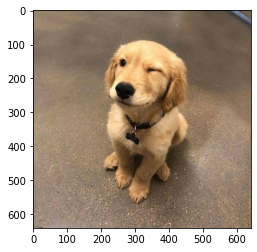

In [22]:
# 사진준비
img_path = '/aiffel/aiffel/workspace/09_study/data/dog.png'  
img_orig = cv2.imread(img_path)

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
# 강아지사진 라벨로 분류
segvalues, output = model.segmentAsPascalvoc(img_path)

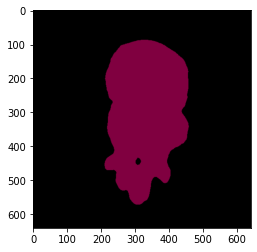

In [24]:
# 분류된 라벨 시각화
plt.imshow(output)
plt.show()

In [25]:
# 강아지 사진은 배경, 강아지 두개로 분류됨
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [26]:
# LABEL_NAMES = [
#     'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
#     'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
#     'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
# ]

# dog은 12 번째 라벨

colormap[12]

array([ 64,   0, 128])

In [27]:
# RGB를 -> BGR
seg_color = (128,0,64)

In [28]:
# 강아지 사진부분은 True, 아닌부분은 False로 변환
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)

# 강아지 있는곳은 255로 아닌곳은 0으로
img_mask = seg_map.astype(np.uint8) * 255

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
print(img_mask_color.shape)

(640, 640)
(640, 640, 3)


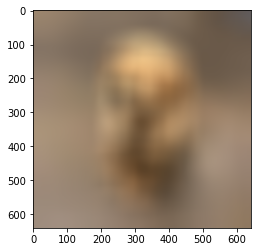

In [29]:
# 전체 이미지 블러처리
img_orig_blur = cv2.blur(img_orig, (100,100))

# 출력이 BGR 이였으니 RGB로 변경해서 출력
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

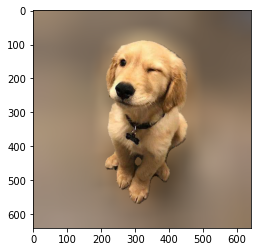

In [30]:
# 강아지(255)인 부분은 원본이미지를, 아닌곳은 블러처리된 배경
img_concat = np.where(img_mask_color==255, img_orig, img_orig_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 배경전환 크로마키사진

### cv2.reisze의 interpolation 옵션
[interpolation 매개변수 설명](https://deep-learning-study.tistory.com/185)

배경 이미지 reshape = (4032, 3024, 3)
내사진 shape = (4032, 3024, 3)


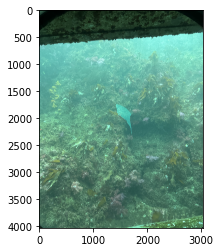

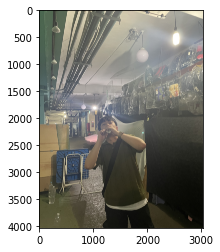

In [31]:
# 사진준비
bg_img_path = '/aiffel/aiffel/workspace/09_study/data/bg_submarine.png'
img_path = '/aiffel/aiffel/workspace/09_study/data/my_image.png'

bg_img_orig = cv2.imread(bg_img_path)
img_orig = cv2.imread(img_path)

# print('원본 배경 이미지 shape =',bg_img_orig.shape) # 원래 배경 이미지 shape (5712, 4272, 3)
# cv2.resize로 배경이미지를 내사진에 맞게 조정 (가로,세로)
bg_img_orig = cv2.resize(bg_img_orig, dsize=(3024, 4032), interpolation=cv2.INTER_LINEAR)
print('배경 이미지 reshape =',bg_img_orig.shape)


print('내사진 shape =',img_orig.shape) # (4032, 3024, 3)

for img in [bg_img_orig, img_orig]:
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [32]:
# 내사진 라벨로 분류
segvalues, output = model.segmentAsPascalvoc(img_path)

In [33]:
# 내사진은 배경, 의자, 사람, 기차(?)로 나뉨
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person
train


In [34]:
# LABEL_NAMES = [
#     'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
#     'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
#     'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
# ]

# 사람(person)만 따로 분류
# person은 15 번째 라벨

colormap[15]

array([192, 128, 128])

In [35]:
# RGB를 -> BGR
seg_color = (128,128,192)

In [36]:
# 내 사진에서 나인 부분은 True, 아닌부분은 False로 변환
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)

# 나 있는곳 255로 아닌곳은 0으로
img_mask = seg_map.astype(np.uint8) * 255

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
print(img_mask_color.shape)

(4032, 3024)
(4032, 3024, 3)


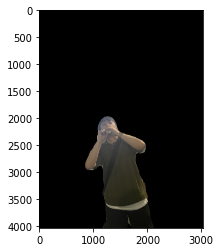

In [37]:
# 나 있는 부분만 출력 (BGR 이였으니 RGB로 변경해서 출력)

only_me_img = np.where(img_mask_color==255, img_orig, False)

plt.imshow(cv2.cvtColor(only_me_img, cv2.COLOR_BGR2RGB))
plt.show()

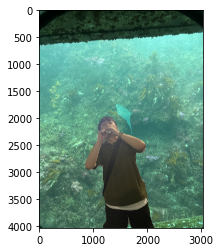

In [38]:
# 내 이미지랑 배경 합성
img_concat = np.where(img_mask_color==255, only_me_img, bg_img_orig)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 내 사진에 train이 포함되어있다 어떻게 없앨 수 있을까 ?

내사진 shape = (4032, 3024, 3)


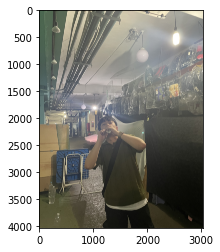

In [42]:
# 내 사진준비
img_path = '/aiffel/aiffel/workspace/09_study/data/my_image.png'

img_orig = cv2.imread(img_path)

print('내사진 shape =',img_orig.shape) # (4032, 3024, 3)


plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

## 랜덤하게 회전

### cv2.getRotationMatrix2D
[getRotationMatrix2D 문서](https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html)

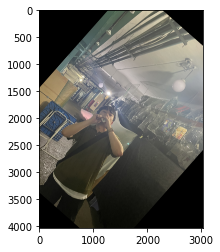

In [43]:
import random

def rotate_random_image(target_img):
    # 랜덤 각도
    random_angle = random.uniform(0, 360)

    # 이미지의 너비와 높이의 중간 지점
    h, w, _ = img_orig.shape
    center = (w // 2, h // 2)

    # 회전 행렬 생성 (왼쪽으로 회전함)
    M = cv2.getRotationMatrix2D(center, random_angle, 1.0)

    # 이미지 회전
    rotated_image = cv2.warpAffine(img_orig, M, (w, h))

    # temp 시각화 이미지 tmp 폴더 저장
    temp_image_path = f'/aiffel/aiffel/workspace/09_study/data/tmp/rotated_image_{random_angle:.2f}.png'
    cv2.imwrite(temp_image_path, rotated_image)
    
    return rotated_image, temp_image_path

rotated_image, temp_image_path = rotate_random_image(img_orig)

# 회전된거 시각화
plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
plt.show()

### train만 제거되는 회전값 찾기
- 'background','chair','person' << 이렇게 분류되는걸 찾고싶음
- 각각 0, 9, 15

In [44]:
# 내사진 라벨로 분류
segvalues, output = model.segmentAsPascalvoc(temp_image_path)

In [45]:
print(type(segvalues['class_ids']))
print(segvalues['class_ids'].shape)
# 1차원 numpy 배열임

<class 'numpy.ndarray'>
(2,)


In [46]:
# 위 랜덤하게 회전한 사진은 배경, 사람 으로만 나뉨 (의자가 빠짐)
for class_id in segvalues['class_ids']:
    rotated_image, _ = rotate_random_image(img_orig)
    print(LABEL_NAMES[class_id])

background
person


In [50]:
target_segvalues = np.array([0,9,15])

for num in range(10): # 10번 테스트
    print(f'{num+1}트')
    # random 회전한 이미지 get
    rotated_image, temp_image_path = rotate_random_image(img_orig)
    
    # random 회전한 이미지 segvalues get
    segvalues, _ = model.segmentAsPascalvoc(temp_image_path)
    
    print(segvalues['class_ids'])

    if np.array_equal(target_segvalues,segvalues['class_ids']):
        print("finish")
        break
    # target이 아니면 지우기
    os.remove(temp_image_path)

1트
[ 0 15]
2트
[ 0 15]
3트
[ 0  9 15]
finish


In [51]:
# 라벨 확인용
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
chair
person


각도 = 339.52


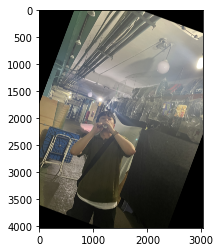

In [52]:
# background, chair, person 으로만 분류된 사진 각도
print('각도 =',temp_image_path.split('_')[-1].replace('.png',''))

# background, chair, person 으로만 분류된 사진 시각화
plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
plt.show()

# 회고
- 배운 점
    - semantic segmentation(목적은 사진에 있는 모든 픽셀을 해당하는 (미리 지정된 개수의) class로 분류)하는방법, 이를 활용해 할 수 있는 아웃포커싱, 배경전환 방법과 문제점을 도출하고 간단하게 실험해봄
- 아쉬운 점
    - 이미지 데이터의 데이터 증강으로 내가 원하는 라벨으로만 원하는 결과를 도출할 수 있었다. 이는 다시 모델에 적용한것이 아니기에 다시 추가적인 학습(파인튜닝 ?) 이 필요할거같은데 이작업 까지는 진행하지 못했다.
    - 시간이 부족해서 데이터 증강중 회전밖에 못해보았다.
- 느낀 점
    - 이렇게 간단하게 semantic segmentation을 적용해보았는데, 사용할땐 몰랐는데 유명한 사진 필터앱 이나 누끼(배경)을 따는 프로그램들을 만든사람들이 존경스럽다
- 어려웠던 점
    - 배경사진 적용할때 처음엔 np.reshape으로 사이즈를 변경했다가 이미지가 완전 이상하게 나왔어서 cv2.resize라는것을 알게됬고 이걸로 해결했었다.